<a href="https://colab.research.google.com/github/gogooma9/SolarGen/blob/qr/src/solar_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import glob
import random

import warnings
warnings.filterwarnings("ignore")

data_path = '/content/drive/MyDrive/SolarGen/'

## Baseline

In [ ]:
train = pd.read_csv(data_path + './data/train/train.csv')
submission = pd.read_csv(data_path + './data/sample_submission.csv')

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
import scipy.interpolate as interpolate


def LOF(data, neighbors = 20 ,conta =0.01):
    temp = data.copy()
    temp = temp[['DHI', 'DNI']]

    clf = LocalOutlierFactor(n_neighbors = neighbors, contamination = conta , p = 2)
    y_pred = clf.fit_predict(temp)

    return y_pred

#p = 1 or 2
#neighbors
#conta
#number of variables

train_afterLOF = pd.DataFrame(LOF(train, 20, "auto"))

outlier_idx = train_afterLOF[train_afterLOF[0] < 1].index
print(len(outlier_idx))

train.drop(outlier_idx, axis=0, inplace=True)

new_idx = [i for i in range(0,52560)]
added_idx_train = train.reindex(new_idx)
train = added_idx_train.interpolate(method = 'linear',limit_direction='forward')
train

266


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0.0,0.0,0.0,0.0,0.0,1.5,69.08,-12.0,0.0
1,0.0,0.0,30.0,0.0,0.0,1.5,69.06,-12.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.6,71.78,-12.0,0.0
3,0.0,1.0,30.0,0.0,0.0,1.6,71.75,-12.0,0.0
4,0.0,2.0,0.0,0.0,0.0,1.6,75.20,-12.0,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094.0,21.0,30.0,0.0,0.0,2.4,70.70,-4.0,0.0
52556,1094.0,22.0,0.0,0.0,0.0,2.4,66.79,-4.0,0.0
52557,1094.0,22.0,30.0,0.0,0.0,2.2,66.78,-4.0,0.0
52558,1094.0,23.0,0.0,0.0,0.0,2.1,67.72,-4.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f868ceffb70>,
      dtype=object)

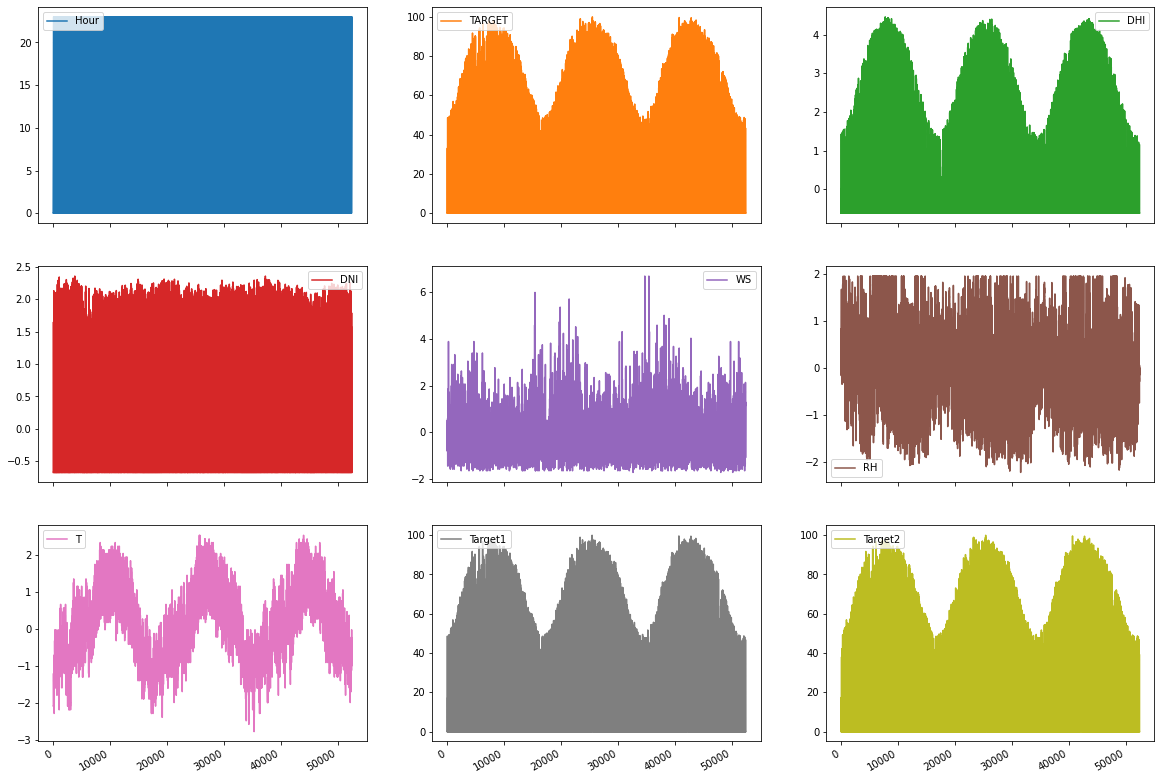

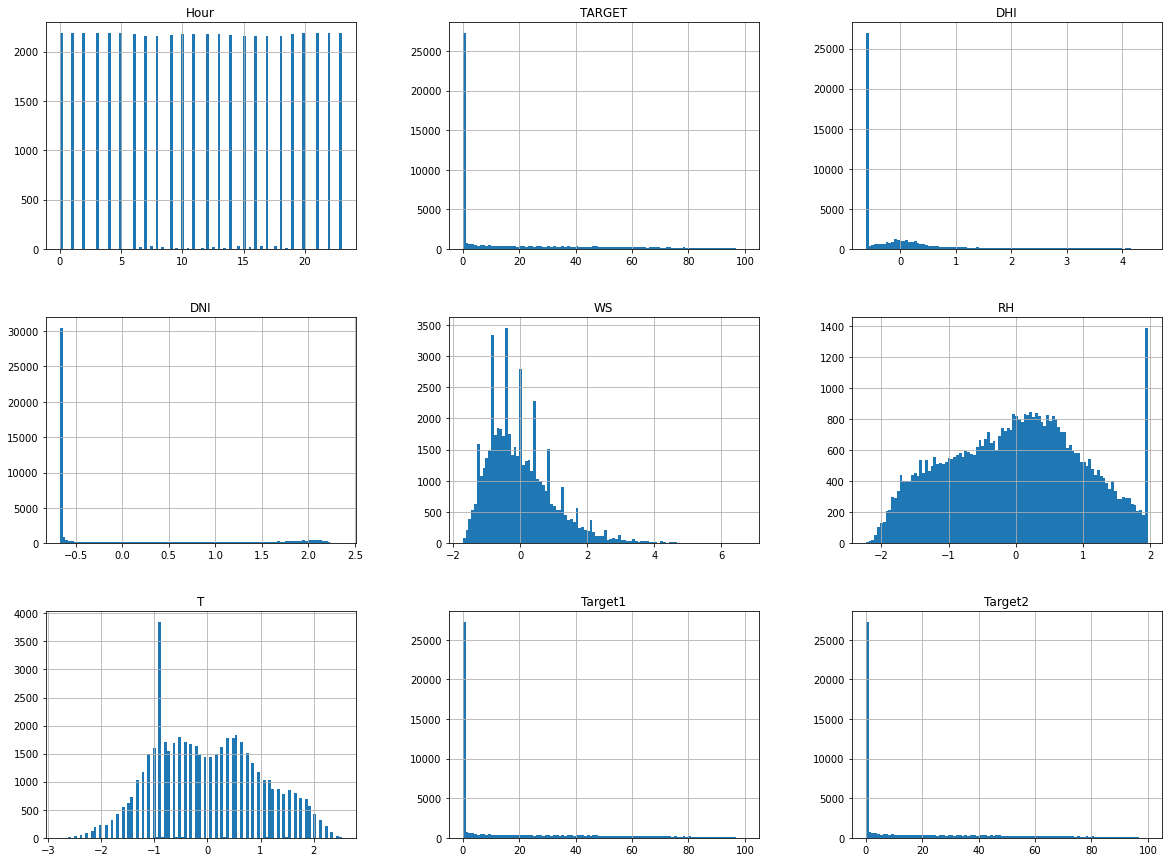

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, 
    MaxAbsScaler, PowerTransformer
)

def scaling(data, scaler, is_train=True):

    temp = data.copy()

    target_cols = ['DHI', 'DNI', 'WS', 'RH', 'T']
    temp = temp[target_cols]
    if is_train: 
        scaler.fit(temp)
    scaled = scaler.transform(temp)

    data[target_cols] = scaled

    return data     

def preprocess_data(data, scalers, is_train=True):
    
    temp = data.copy()

    for scaler in scalers:
        temp = scaling(temp, scaler, is_train)

    temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]

scalers = []
#scalers.append(MinMaxScaler())
scalers.append(StandardScaler())
# scalers.append(RobustScaler())
# scalers.append(MaxAbsScaler())
# scalers.append(QuantileTransformer(n_quantiles=900))
# scalers.append(PowerTransformer(method='yeo-johnson'))
# scalers.append(PowerTransformer(method='box-cox'))

df_train = preprocess_data(train, scalers)
df_train.plot(subplots=True, layout=(3,3), figsize=(20,15))
df_train.hist(bins = 100, figsize=(20,15))

In [ ]:
df_test = []

for i in range(81):
    file_path = data_path + './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, scalers, is_train=False)
    df_test.append(temp)

X_test = pd.concat(df_test)
X_test.shape

(3888, 7)

In [ ]:
df_train

,Hour,TARGET,DHI,DNI,WS,RH,T,Target1,Target2
0,0.0,0.0,-0.619672,-0.672078,-0.670041,0.557111,-2.090420,0.0,0.0
1,0.0,0.0,-0.619672,-0.672078,-0.670041,0.556204,-2.090420,0.0,0.0
2,1.0,0.0,-0.619672,-0.672078,-0.599945,0.679553,-2.090420,0.0,0.0
3,1.0,0.0,-0.619672,-0.672078,-0.599945,0.678192,-2.090420,0.0,0.0
4,2.0,0.0,-0.619672,-0.672078,-0.599945,0.834645,-2.090420,0.0,0.0
...,...,...,...,...,...,...,...,...,...
52459,21.0,0.0,-0.619672,-0.672078,0.731866,-0.037410,-1.009826,0.0,0.0
52460,22.0,0.0,-0.619672,-0.672078,1.012248,-0.116317,-1.108062,0.0,0.0
52461,22.0,0.0,-0.619672,-0.672078,1.152438,-0.117224,-1.108062,0.0,0.0
52462,23.0,0.0,-0.619672,-0.672078,1.292629,-0.015189,-1.108062,0.0,0.0


In [ ]:
X_train_1, Y_train_1 = df_train.iloc[:, :-2], df_train.iloc[:, -2]
X_train_2, Y_train_2 = df_train.iloc[:, :-2], df_train.iloc[:, -1]

In [ ]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.quantile_regression as Q_reg
import matplotlib.pyplot as plt

def Qreg(q, X_train, Y_train):
   # (a) Modeling 
   mod = Q_reg.QuantReg(Y_train, X_train).fit(q=q)
    
   # (b) Get the coefficients and the lower and upper bounds
   coefs = pd.DataFrame()
   coefs['param'] = mod.params
   coefs = pd.concat([coefs,mod.conf_int()],axis=1) # "mod.conf_int" will give the lower and upper bounds
   coefs['q'] = q
   coefs.columns = ['beta','beta_lower','beta_upper','quantile']
    
   # (c) Predictions
   pred = pd.Series(mod.predict(X_test).round(2))
   return coefs, pred


def train_data(X_train, Y_train):
    Qreg_coefs = pd.DataFrame()
    Qreg_actual_pred = pd.DataFrame()

    for q in quantiles:
        coefs, pred = Qreg(q, X_train, Y_train)
        Qreg_coefs = pd.concat([Qreg_coefs,coefs])
        Qreg_actual_pred = pd.concat([Qreg_actual_pred,pred],axis=1)

    Qreg_actual_pred.columns=quantiles

    return Qreg_actual_pred, Qreg_coefs

Qreg_actual_pred, Qreg_coefs = train_data(X_train_1, Y_train_1)
Qreg_actual_pred

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
288,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.01,-0.45
289,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.01,-0.41
290,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.01,-0.01
291,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.01,-0.04
292,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.00,0.32
...,...,...,...,...,...,...,...,...,...
331,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.10,7.21
332,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.10,7.57
333,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.10,7.58
334,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.11,7.93


In [ ]:
#Score(error)

# from sklearn.model_selection import cross_val_score

# def Qreg_score(q, X_train, Y_train):
   # (a) Modeling 
    # mod = Q_reg.QuantReg(Y_train, X_train)
    # mod.fit(q=q)
    
    # scores = cross_val_score(mod, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error')
   
    # return scores
# q = 0.1
# Qreg_score(q, X_train_1, Y_train_1)

In [ ]:
Qreg_coefs['beta_abs'] = np.abs(Qreg_coefs['beta'] ) 
Qreg_coefs = Qreg_coefs.sort_values(by=['quantile','beta_abs'])
Qreg_coefs

,beta,beta_lower,beta_upper,quantile,beta_abs
Hour,-4.111687e-09,-0.001664,0.001663,0.1,4.111687e-09
RH,-1.191207e-08,-0.020906,0.020906,0.1,1.191207e-08
WS,2.031410e-08,-0.015863,0.015864,0.1,2.031410e-08
T,-3.888238e-08,-0.020328,0.020328,0.1,3.888238e-08
DNI,1.801347e-01,0.144784,0.215486,0.1,1.801347e-01
...,...,...,...,...,...
Hour,3.784834e-01,0.375026,0.381941,0.9,3.784834e-01
WS,5.045660e-01,0.472419,0.536713,0.9,5.045660e-01
TARGET,1.211405e+00,1.208996,1.213814,0.9,1.211405e+00
DNI,-6.707361e+00,-6.782604,-6.632118,0.9,6.707361e+00


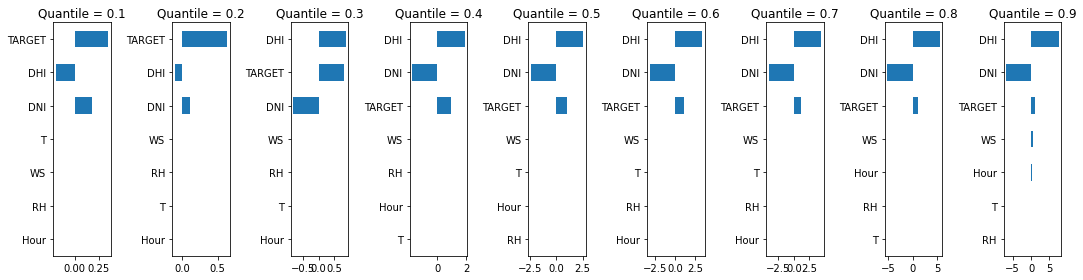

In [ ]:
# Get the absolute value of the coefficients for ranking
Qreg_coefs['beta_abs'] = np.abs(Qreg_coefs['beta'] ) 
Qreg_coefs = Qreg_coefs.sort_values(by=['quantile','beta_abs'])

fig = plt.figure(figsize=(15, 4))

n = len(quantiles)

for i in range(n):
    plt.subplot(1, n, i+1)
    w = Qreg_coefs[Qreg_coefs['quantile']==quantiles[i]]
    w['beta'].plot.barh()
    plt.title('Quantile = ' + str(quantiles[i] ))

fig.tight_layout()
plt.show()

In [ ]:
results_1 = train_data(X_train_1,Y_train_1)
results_2 = train_data(X_train_2,Y_train_2)

In [ ]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.values
submission

In [ ]:
submission.to_csv(data_path + './data/submission.csv', index=False)